In [1]:
from mlrl.maze.maze_env import make_maze_env
from mlrl.maze.maze_state import MazeState
from mlrl.meta.search_tree import SearchTree
from mlrl.meta.meta_env import MetaEnv
from mlrl.maze.manhattan_q import ManhattanQHat

from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.environments.gym_wrapper import GymWrapper


object_env = make_maze_env(
    seed=0, maze_size=(5, 5), goal_reward=1, render_shape=(64, 64),
    generate_new_maze_on_reset=True
)

q_hat = ManhattanQHat(object_env)
initial_tree = SearchTree(object_env, MazeState.extract_state(object_env), q_hat)
meta_env = MetaEnv(object_env, initial_tree, max_tree_size=10, 
                   object_action_to_string=lambda a: object_env.ACTION[a])

env = TFPyEnvironment(GymWrapper(meta_env))


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


pygame 2.1.0 (SDL 2.0.16, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


<AxesSubplot:>

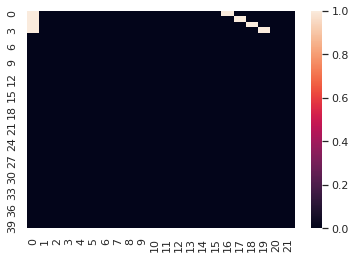

In [2]:
ts = env.current_time_step()
tokens = ts.observation['search_tree_tokens']
mask = ts.observation['valid_action_mask']

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.heatmap(tokens[0].numpy())

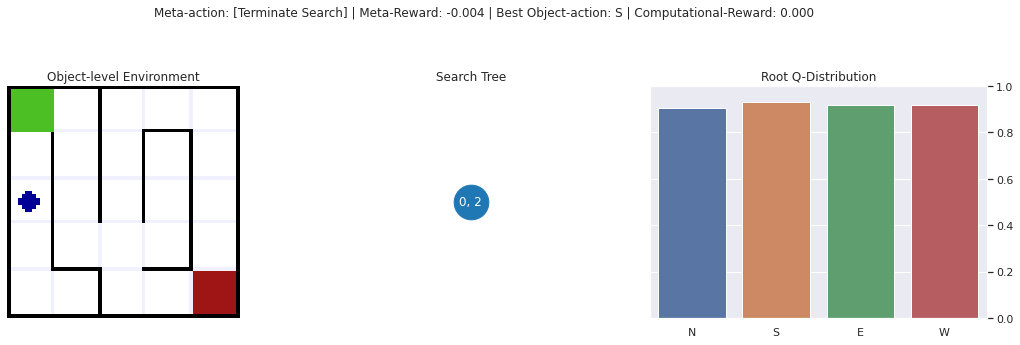

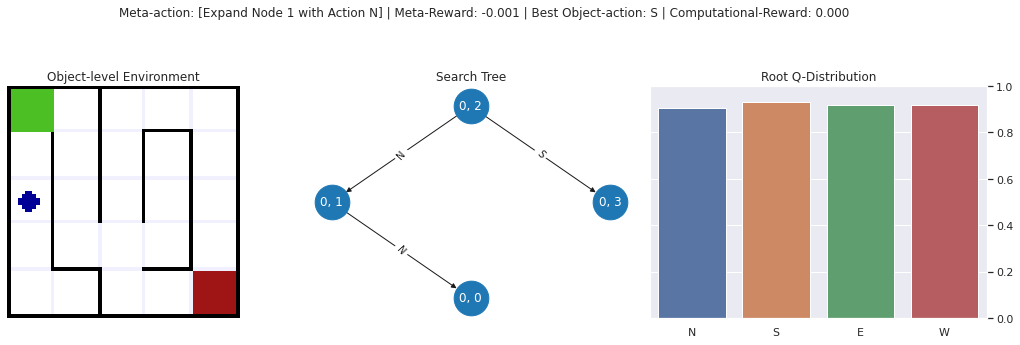

In [4]:
meta_env.step(0)
meta_env.step(0)
meta_env.render(plt_show=True)
meta_env.step(1)
meta_env.step(2)
meta_env.step(5)
meta_env.render(plt_show=True)
meta_env.reset();

In [6]:
def mask_invalid_action_constraint_splitter(observation):
    return observation['search_tree_tokens'], observation['valid_action_mask']


from mlrl.meta.search_q_model import SearchQModel

import tensorflow as tf
from tf_agents.networks import sequential
from tf_agents.agents.dqn import dqn_agent
from tf_agents.utils import common
from tf_agents.specs import tensor_spec


# weights_path = './runs/dqn_agent/simple_single_grid_dqn-16638260065752182/model'
weights_path = './q_net.h5'

q_net = SearchQModel()
q_net(env.current_time_step().observation['search_tree_tokens'])  # build the model
q_net.load_weights(weights_path)

optimizer = tf.keras.optimizers.Adam(learning_rate=0)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    env.time_step_spec(),
    env.action_spec(),
    q_network=sequential.Sequential([q_net]),
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    observation_and_action_constraint_splitter=mask_invalid_action_constraint_splitter,
    train_step_counter=train_step_counter
)

agent.initialize()

INFO:tensorflow:Assets written to: ram://283d7ece-269a-430b-b92c-2755512c6bb3/assets


INFO:tensorflow:Assets written to: ram://283d7ece-269a-430b-b92c-2755512c6bb3/assets


In [7]:
from mlrl.utils.render_utils import create_policy_eval_video, embed_mp4

embed_mp4(create_policy_eval_video(agent.policy, env, max_steps=30))

In [9]:
q_net.q_network.summary()

Model: "q_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10, 192)           3648      
                                                                 
 reshape_1 (Reshape)         (None, 40, 48)            0         
                                                                 
 prepend_terminate_token_1 (  (None, 41, 48)           0         
 PrependTerminateToken)                                          
                                                                 
 transformer_2 (Transformer)  (None, 41, 48)           11200     
                                                                 
 transformer_3 (Transformer)  (None, 41, 48)           11200     
                                                                 
 dense_3 (Dense)             (None, 41, 1)             49        
                                                         